In [1]:
import itertools
from basics import *
from plotting import *
from scipy import stats
import seaborn as sns
import yaml
from matplotlib import cm

plt.style.use("paper")

In [2]:
names = ["soap", "latinn", "schnet", "mace"]
facets = [100, 111, 211, 331, 410, 711]
root_dir = "../data/02-extrapolation"

dfs = {
    name: pd.read_csv(f"{root_dir}/{name}.csv", index_col=0)
    for name in names
}    

In [3]:
df = []
for name, subdf in dfs.items():
    _df = subdf.copy()
    _df["arch"] = name
    if "model" in _df.columns:
        _df["model"] = _df["model"].apply(int).apply(str)

    df.append(_df)
    
df = pd.concat(df, axis=0)

In [4]:
df

,facet,model,rmse,mae,spearman,pearson,arch,exp,exp-model
0,100,1,0.131036,0.113885,0.995518,0.999785,soap,NaN,NaN
1,100,2,0.145741,0.127446,0.992736,0.999699,soap,NaN,NaN
2,100,3,0.123272,0.107315,0.994862,0.999767,soap,NaN,NaN
3,100,4,0.133095,0.115727,0.992579,0.999682,soap,NaN,NaN
4,100,5,0.123740,0.108677,0.994855,0.999775,soap,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1,111,NaN,0.130721,0.110847,0.995141,0.997038,mace,NaN,NaN
2,211,NaN,0.124749,0.101214,0.982879,0.994540,mace,NaN,NaN
3,331,NaN,0.236133,0.190670,0.961904,0.971698,mace,NaN,NaN
4,410,NaN,0.040233,0.031465,0.993861,0.998857,mace,NaN,NaN


## In-domain errors

In [5]:
fdf = df.loc[df.facet == 711]
fdf = fdf.groupby(["arch"])["rmse"].mean().reset_index()

In [6]:
fdf

,arch,rmse
0,latinn,0.027427
1,mace,0.014552
2,schnet,0.029424
3,soap,0.040646


## Out-of-domain errors

In [7]:
subdf = df.groupby(["arch", "facet"])["rmse"].mean().reset_index()

In [8]:
table = subdf.pivot(index="arch", columns="facet", values="rmse")
table = table.loc[["soap", "schnet", "latinn", "mace"]]
table = table * 1000

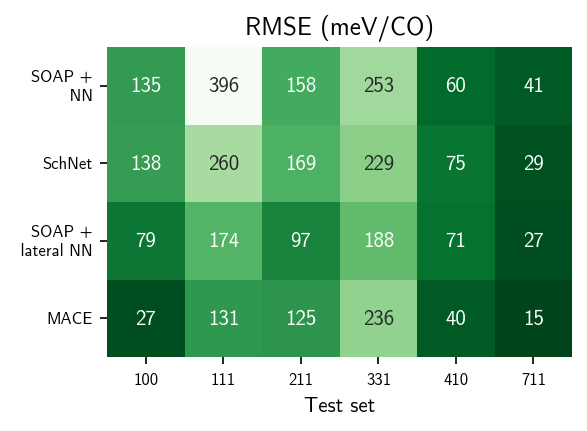

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    table,
    annot=True,
    fmt=".0f",
    cbar=False,
    square=True,
    ax=ax,
    cmap="Greens_r"
)

ax.set_xlabel("Test set")
ax.set_ylabel("")
ax.set_yticklabels([
    "SOAP +\n NN",
    "SchNet",
    "SOAP +\n lateral NN",
    "MACE"
], rotation=0)

ax.set_title("RMSE (meV/CO)")
savefig(fig, "03-extrapolation-models-rmse.pdf")
plt.show()

## Plotting the out of distribution errors

In [10]:
ood = table[[100, 111, 211, 331, 410]].mean(1)
iid = table[711]

vals = pd.concat([iid, ood], axis=1)
vals.columns = ["in", "out"]
vals = vals

ood_std = table[[100, 111, 211, 331, 410]].std(1)

In [11]:
subdf = vals.stack().reset_index()
subdf.columns = ["model", "dset", "rmse"]
subdf.loc[:, "rmse"] = subdf["rmse"]

In [12]:
vals

,in,out
arch,,
soap,40.646041,200.512880
schnet,29.423563,174.059942
latinn,27.426692,121.866152
mace,14.551991,111.819717


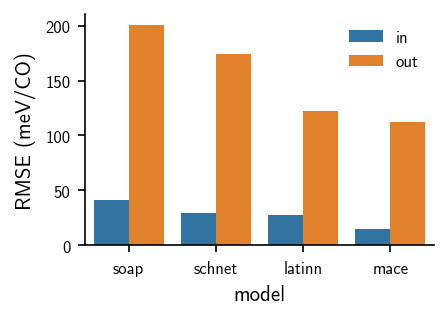

In [13]:
fig, ax = plt.subplots(figsize=(3, 2))

sns.barplot(
    data=subdf,
    y="rmse",
    x="model",
    hue="dset",
    orient="v",
    ax=ax,
)

ax.legend(frameon=False)

ax.set_ylabel("RMSE (meV/CO)")

savefig(fig, "03-extrapolation-models-mean.pdf")
plt.show()